<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Examples: Multiple linear regression: Advanced regression analysis 1

© ExploreAI Academy

In this notebook, we will delve deeper into multiple linear regression. We employ statistical tests and diagnostics from the Statsmodels library to assess model quality comprehensively. Using the MTCars dataset, we explore linearity and multicollinearity, as well as fit a model, enriching our regression analysis toolkit.

## Learning Objectives

By the end of this notebook, you should be able to:
* Understand the importance of statistical diagnostics in regression analysis.
* Perform exploratory data analysis on a regression dataset.
* Check for linearity between predictor and response variables.
* Identify and address multicollinearity issues in the dataset.
* Fit a multiple linear regression model using Statsmodels and interpret its summary 


## Introduction

Previously, we learned about fitting a regression model using multiple predictors using `sklearn`. It was an easy process requiring the same steps as fitting a simple linear regression model using just one predictor. We then performed a rudimentary quality assessment of the fitted model using the MSE and RMSE metrics.

Unfortunately, in terms of regression, `sklearn` has a very limited set of metrics and tools with which we can evaluate the quality of our fitted models. Furthermore, we are also in need of additional methods which will allow us to check the properties of our original data before we perform any modelling.  

In this train, we cover a thorough set of steps grounded in statistical tests to better determine the quality of a regression model. This train is an adaptation of [this Medium article](https://towardsdatascience.com/how-do-you-check-the-quality-of-your-regression-model-in-python-fa61759ff685).

## The dataset - `mtcars`

For this train, we continue to make use of the MTCars dataset, to which we've already been introduced. We begin by importing some libraries, which will help us load and explore our data. 

In [2]:
# Add lsp functionalities
!poetry add jupyterlab-lsp
!poetry add 'python-lsp-server[rope]' python-lsp-ruff

The following packages are already present in the pyproject.toml and will be skipped:

  - jupyterlab-lsp

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
The following packages are already present in the pyproject.toml and will be skipped:

  - python-lsp-ruff

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Using version ^1.10.1 for python-lsp-server

Updating dependencies
Resolving dependencies... (1.0s)

No dependencies to install or update


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#Load the data 
df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/mtcars.csv', index_col=0)
df.head(10)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
model,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2


In [5]:
#Explore the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,32.0,20.090625,6.026948,10.400,15.42500,19.200,22.80,33.900
cyl,32.0,6.187500,1.785922,4.000,4.00000,6.000,8.00,8.000
disp,32.0,230.721875,123.938694,71.100,120.82500,196.300,326.00,472.000
hp,32.0,146.687500,68.562868,52.000,96.50000,123.000,180.00,335.000
drat,32.0,3.596563,0.534679,2.760,3.08000,3.695,3.92,4.930
wt,32.0,3.217250,0.978457,1.513,2.58125,3.325,3.61,5.424
qsec,32.0,17.848750,1.786943,14.500,16.89250,17.710,18.90,22.900
vs,32.0,0.437500,0.504016,0.000,0.00000,0.000,1.00,1.000
am,32.0,0.406250,0.498991,0.000,0.00000,0.000,1.00,1.000
gear,32.0,3.687500,0.737804,3.000,3.00000,4.000,4.00,5.000


It appears both `vs` and `am` are categorical variables. From the dataset description [available here](https://rpubs.com/neros/61800), `vs` takes on a value of 0/1 depending on whether the engine layout is a *V* or *straight*, and `am` takes on a 0/1 value depending on whether the transmission is *automatic* or *manual*, both respectively.

Note that they don't need to be one-hot encoded because they are binary categorical variables (only two categories each), and they already make use of zeros and ones.

## Checking for linearity

The first thing we need to check is the mathematical relationship between each predictor variable and the response variable. What we are looking for here is known as linearity. A linear relationship means that a change in the response *Y* due to a one-unit change in the predictor $X_j$ is constant, regardless of the value of $X_j$.

If we fit a regression model to a non-linear dataset, it will fail to adequately capture the relationship in the data - resulting in a mathematically inappropriate model. To check for linearity, we can produce scatter plots of each predictor against the response variable. The intuition here is that we are looking for obvious linear relationships.

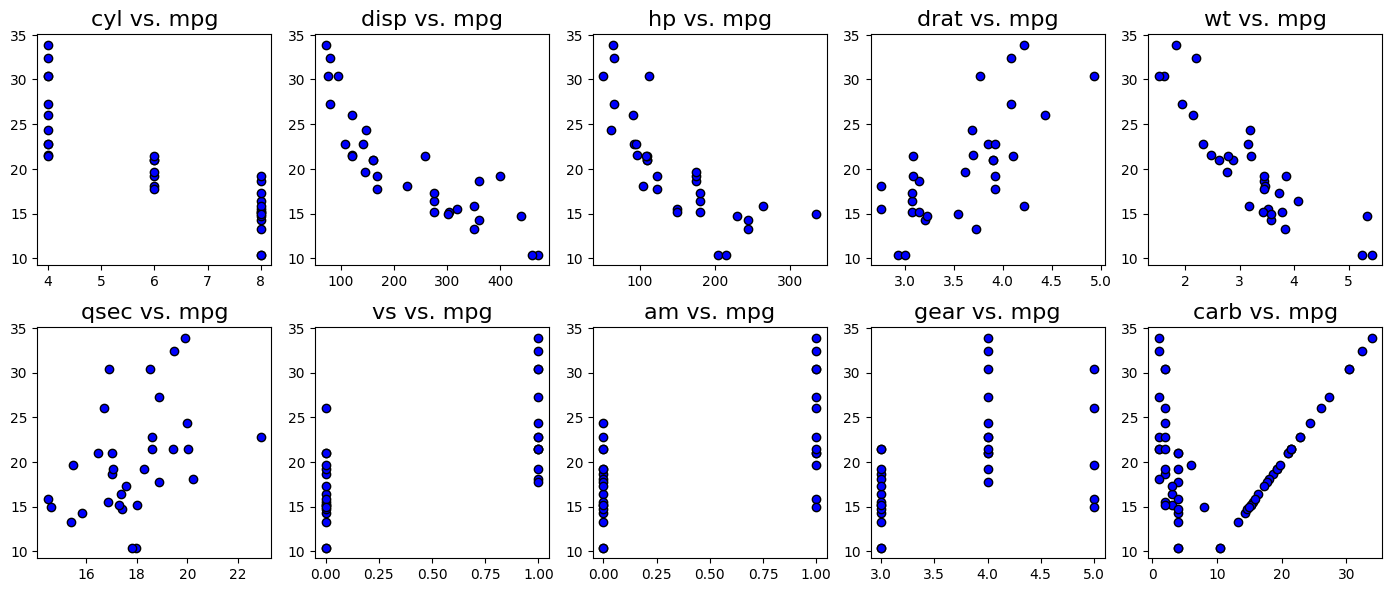

In [14]:
fig, axs = plt.subplots(2,5, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()

for index, column in enumerate(df.columns):
    axs[index-1].set_title("{} vs. mpg".format(column),fontsize=16)
    axs[index-1].scatter(x=df[column],y=df['mpg'],color='blue',edgecolor='k')
    
fig.tight_layout(pad=1)

It appears at least half of the variables, including all five on the top row, have an approximately linear relationship. Here, a trend between each of `cyl, disp, hp, drat, wt`, `qsec` and `mpg` seems to exist. However, `carb` and `gear` exhibit no linearity with `mpg`.

Based on these observations, it appears there is sufficient linearity present to proceed with applying a linear regression model. Let's continue.

We'll create a copy of the dataset so that we can play with it and process it using `statsmodels.OLS()`, which is the least squares regression module within the `statsmodels` library. We'll be carrying out our regression with this module.

In [6]:
df1 = df.copy()

## Checking for multicollinearity

Multicollinearity refers to the presence of a strong correlation among two or more of the predictor variables in the dataset. The presence of any correlation among predictors is detrimental to model quality for two reasons:

- It tends to increase the standard error;

- It becomes difficult to estimate the effect of any one predictor variable on the response variable.

We will check for multicollinearity by generating pairwise scatter plots among predictors and further generating a correlation heatmap.

### Pairwise scatter plots

As can be inferred by the name, a pairwise scatter plot simply produces a visual $n \times n$ matrix, where $n$ is the total number of variables compared, in which each cell represents the relationship between two variables. The diagonal cells of this visual represent the comparison of a variable with itself, and as such, they are substituted by a representation of the distribution of values taken by the visual.

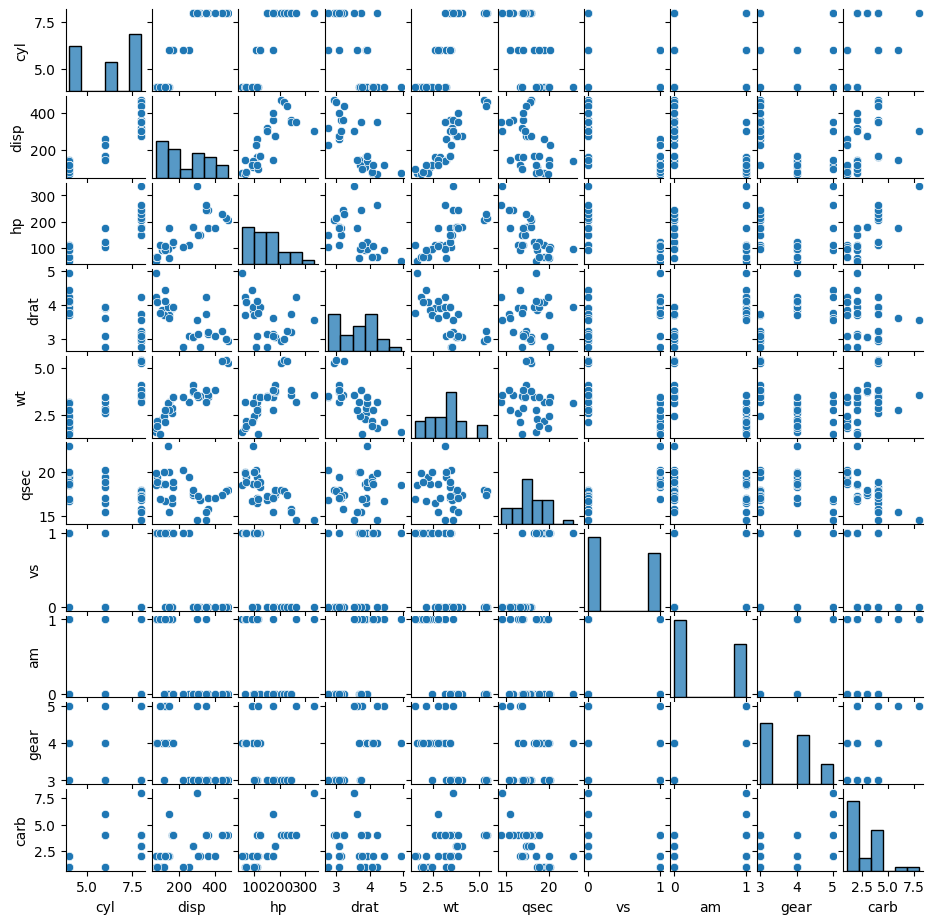

In [17]:
# Due to the number of visuals created, this codeblock takes about one minute to run.
from seaborn import pairplot
g = pairplot(df1.drop('mpg', axis='columns'))
g.fig.set_size_inches(9,9)

### Correlation heatmap

Another way we can visually discover linearity between two or more variables within our dataset is through the use of a correlation heatmap. Similar to the pairwise scatter plot we produced above, this visual presents a matrix in which each row represents a distinct variable, with each column representing the correlation between this variable and another one within the dataset.    

In [10]:
!poetry add statsmodels

The following packages are already present in the pyproject.toml and will be skipped:

  - statsmodels

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [11]:
# We only compare the predictor variables, and thus drop the target `mpg` column.
corr = df1.drop('mpg', axis='columns').corr()

In [12]:
from statsmodels.graphics.correlation import plot_corr

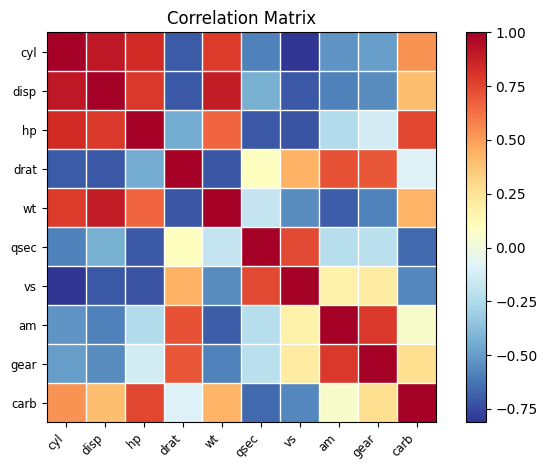

In [13]:
fig=plot_corr(corr,xnames=corr.columns)

From both the pairwise scatterplot and correlation heatmap, we can see several strong correlations among predictors:

- `disp` and `cyl`;
- `cyl` and `hp`;
- `hp` and `carb`;
- `cyl` and `vs`;
- `cyl` and `wt`.

Let's keep these in mind when we build and continue to check the quality of our model.

## Fitting the model using `statsmodels.OLS`

As was previously motivated within the train, `sklearn` is limited in terms of the metrics and tools available to evaluate the appropriateness of the regression models we fit. Thus, as a means to expand our analysis, we import the `statsmodels` library, which has a rich set of statistical tools that we can use. 

In [14]:
import statsmodels.formula.api as sm

### Generating the regression string

Those who are familiar with the R language will know that fitting a machine learning model requires a kind of string of the form:

`y ~ X`

which is read as follows: "Regress y on X". The `statsmodels` library works similarly, so we need to generate an appropriate string to feed to the method when we wish to fit the model.

In [17]:
formula_str = df1.columns[0]+' ~ '+'+'.join(df1.columns[1:]); formula_str

'mpg ~ cyl+disp+hp+drat+wt+qsec+vs+am+gear+carb'

In other words, we will regress `mpg` on all of the predictors.

### Construct and fit the model

We now go ahead and fit our model. We use the `ols` or Ordinary Least Squares regression model from the `statsmodels` library to do this:  

In [18]:
model=sm.ols(formula=formula_str, data=df1)

In [19]:
fitted = model.fit()

### Print model summary

Unlike the `sklearn` models we've seen so far which only produce a couple of statistics following the fitting process, our new model produces a rich set of statistics to help us analyse its appropriateness.   

In [20]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     13.93
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           3.79e-07
Time:                        15:43:45   Log-Likelihood:                -69.855
No. Observations:                  32   AIC:                             161.7
Df Residuals:                      21   BIC:                             177.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3034     18.718      0.657      0.5

The above result provides the summary output of the multiple linear regression model fitted to the data.

On the top of the summary report, we'll find the **Model information section**, which provides details about the type of model utilised and the estimation method employed. Following this, the **Model fit** section offers crucial metrics such as R-squared and adjusted R-squared, providing insights into how well the model fits the data. Additionally, the F-statistic, accompanied by its associated p-value, evaluates the overall significance of the model. Moving further down, the **Coefficients table** displays estimates, standard errors, t-values, and p-values for each predictor variable, elucidating their individual significance and impact on the dependent variable. Lastly, we'll encounter additional diagnostics, encompassing various diagnostic tests aimed at assessing the model's assumptions and identifying potential issues like multicollinearity or non-normality of residuals. This succinct summary encapsulates the most salient components of a stats model summary report, offering a comprehensive overview of the model's performance and reliability.



#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>